/tmp/ipython-input-1-87300090.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("INFY.NS", start="2020-01-01", end="2025-07-02")
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training model for 100 epochs...
Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0647 - val_loss: 2.8553e-04
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010 - val_loss: 3.2463e-04
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.6332e-04 - val_loss: 3.2306e-04
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.3272e-04 - val_loss: 3.2665e-04
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.0723e-04 - val_loss: 4.1566e-04
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.3926e-04 - val_loss: 2.7123e-04
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.5583e-04 - val_loss: 4.2472e-04
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.3841e-04 - val_loss: 2.6638e-04
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7495e-04 - val_loss: 2.6708e-04
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.2653e-04 - val_loss: 2.7333e-04
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━

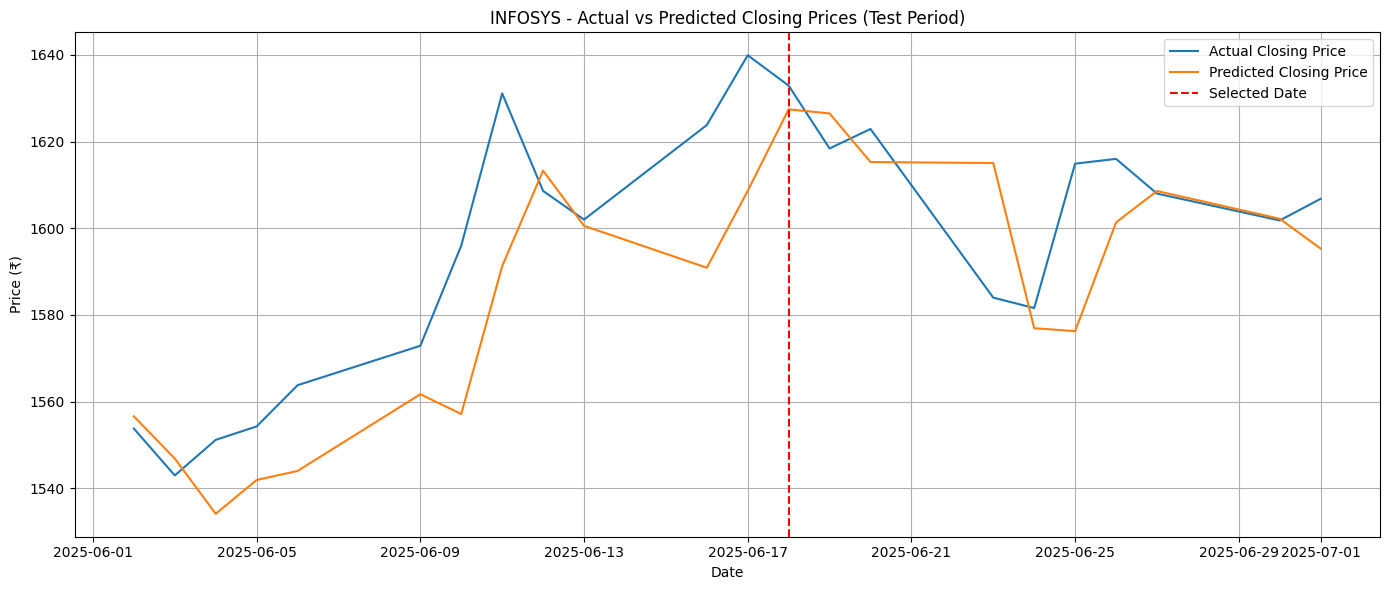

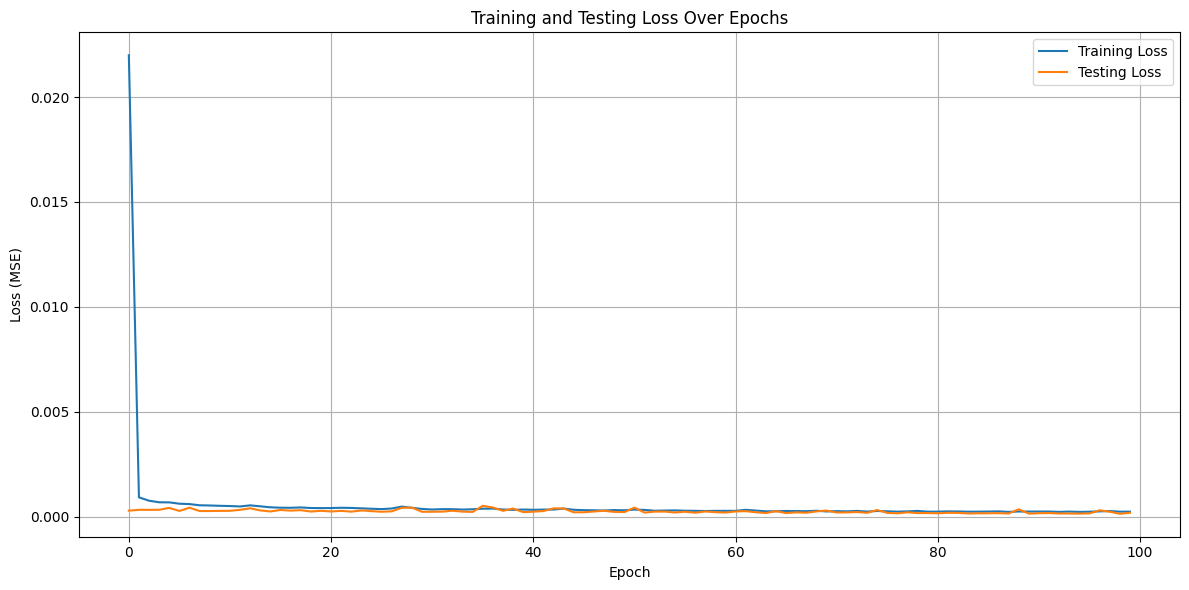

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import date
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler


np.random.seed(42)

print("Downloading INFOSYS historical data...")
df = yf.download("INFY.NS", start="2020-01-01", end="2025-07-02")

if df.empty:
    print("ERROR: No data returned.")
    exit()

df = df[["Close"]]
df.reset_index(inplace=True)
df["Date"] = pd.to_datetime(df["Date"]).dt.date
df.sort_values("Date", inplace=True)


train_df = df[df["Date"] <= date(2025, 5, 31)]
test_df = df[(df["Date"] >= date(2025, 6, 1)) & (df["Date"] <= date(2025, 7, 1))]

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(df["Close"].values.reshape(-1, 1))

# Create sequences
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(scaled_close)):
    X.append(scaled_close[i-sequence_length:i, 0])
    y.append(scaled_close[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Determine split index
split_index = len(train_df) - sequence_length
X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]
test_dates = df["Date"].values[sequence_length + split_index:]

# Build SimpleRNN model
model = Sequential()
model.add(SimpleRNN(50, activation="tanh", input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")

# Train model with validation on test data
print("Training model for 100 epochs...")
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Predict on test data
predicted_scaled = model.predict(X_test)
predicted = scaler.inverse_transform(predicted_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# --- Training Set Metrics ---
train_pred_scaled = model.predict(X_train)
train_pred = scaler.inverse_transform(train_pred_scaled)
train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

mse_train = np.mean((train_pred - train_actual)**2)
mae_train = np.mean(abs(train_pred - train_actual))
mape_train = np.mean(abs(train_pred - train_actual) / train_actual) * 100
accuracy_train = 100 - mape_train
avg_train_price = np.mean(train_actual)
mse_train_percent = (mse_train / avg_train_price) * 100
mae_train_percent = (mae_train / avg_train_price) * 100

# --- Test Set Metrics ---
mse = np.mean((predicted - actual) ** 2)
mae = np.mean(abs(predicted - actual))
avg_price = np.mean(actual)
mse_percent = (mse / avg_price) * 100
mae_percent = (mae / avg_price) * 100
mape = np.mean(abs(predicted - actual) / actual) * 100
accuracy = 100 - mape

# Print metrics
print("\n========== Training Set Metrics ==========")
print(f"MSE: {mse_train:.4f} ({mse_train_percent:.4f}% of avg price)")
print(f"MAE: {mae_train:.4f} ({mae_train_percent:.4f}% of avg price)")
print(f"Accuracy: {accuracy_train:.2f}%")

print("\n========== Test Set Metrics ==========")
print(f"MSE: {mse:.4f} ({mse_percent:.4f}% of avg price)")
print(f"MAE: {mae:.4f} ({mae_percent:.4f}% of avg price)")
print(f"Accuracy: {accuracy:.2f}%")
print("=========================================\n")

# Prompt user for date
while True:
    user_input = input("Enter a date between 2025-06-01 and 2025-07-01 (YYYY-MM-DD): ").strip()
    try:
        user_date = datetime.datetime.strptime(user_input, "%Y-%m-%d").date()
    except ValueError:
        print("Invalid format. Try again.")
        continue
    if not (date(2025, 6, 1) <= user_date <= date(2025, 7, 1)):
        print("Date out of range.")
        continue
    if user_date not in test_dates:
        print("Date not in test data.")
        continue
    break

# Find index
idx = np.where(test_dates == user_date)[0][0]
pred_price = predicted[idx][0]
act_price = actual[idx][0]
error_pct = abs(pred_price - act_price) / act_price * 100

# Display prediction
print(f"\nFor {user_date}:")
print(f"Predicted closing price: ₹{pred_price:.2f}")
print(f"Actual closing price: ₹{act_price:.2f}")
print(f"Absolute error: {error_pct:.2f}%")

# Plot actual vs predicted prices
plt.figure(figsize=(14, 6))
plt.plot(test_dates, actual, label="Actual Closing Price")
plt.plot(test_dates, predicted, label="Predicted Closing Price")
plt.axvline(x=np.datetime64(user_date), color="red", linestyle="--", label="Selected Date")
plt.xlabel("Date")
plt.ylabel("Price (₹)")
plt.title("INFOSYS - Actual vs Predicted Closing Prices (Test Period)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Combined loss plot
plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Testing Loss")
plt.title("Training and Testing Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-2-1231537925.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("INFY.NS", start="2020-01-01", end="2025-07-02")
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training model for 500 epochs...
Epoch 1/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0127 - val_loss: 0.0011
Epoch 2/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.2819e-04 - val_loss: 3.5393e-04
Epoch 3/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.1354e-04 - val_loss: 3.8001e-04
Epoch 4/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.5981e-04 - val_loss: 4.4892e-04
Epoch 5/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.9565e-04 - val_loss: 3.6194e-04
Epoch 6/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.2531e-04 - val_loss: 4.7723e-04
Epoch 7/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.6104e-04 - val_loss: 3.4623e-04
Epoch 8/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.8510e-04 - val_loss: 3.4462e-04
Epoch 9/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 5.8349e-04 - val_loss: 3.1741e-04
Epoch 10/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 5.3839e-04 - val_loss: 5.9057e-04
Epoch 11/500
40/40 ━━━━━━━━━━━━━━━

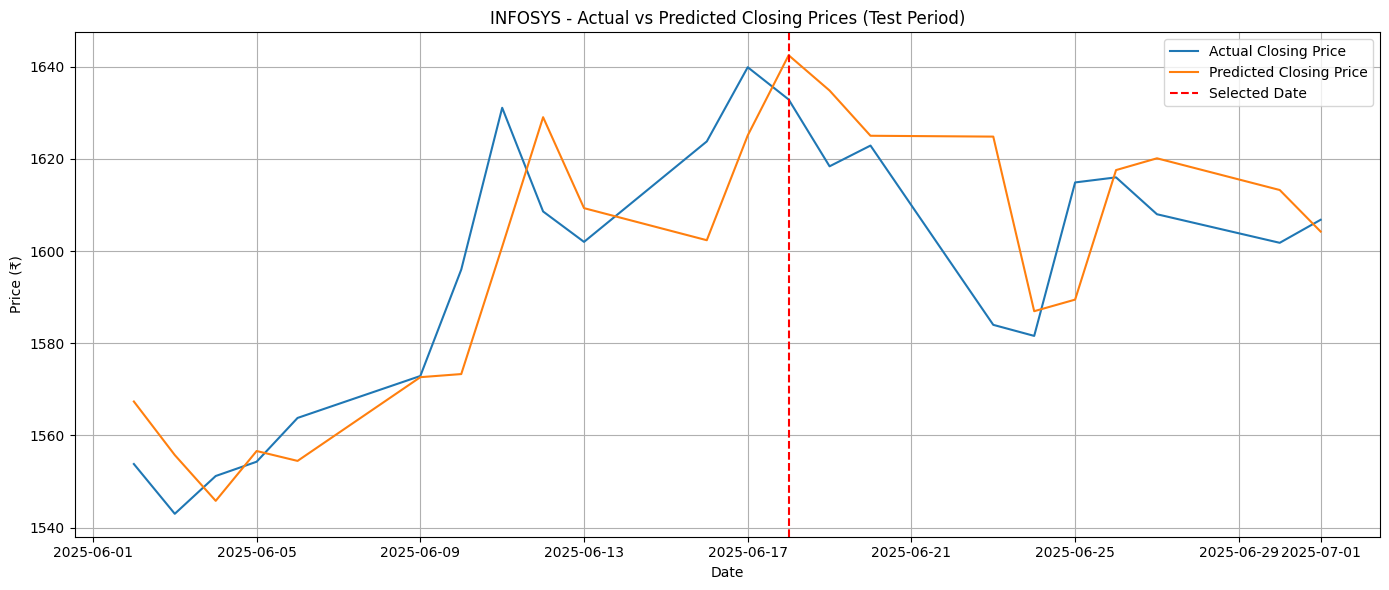

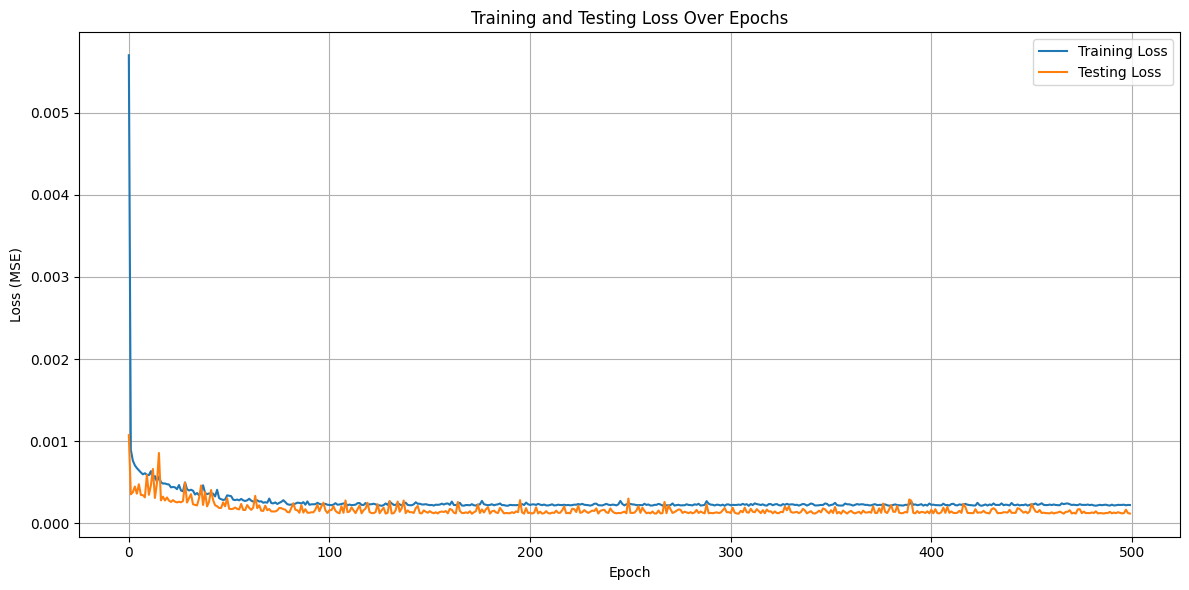

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import date
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler

# For reproducibility
np.random.seed(42)

# Download data
print("Downloading INFOSYS historical data...")
df = yf.download("INFY.NS", start="2020-01-01", end="2025-07-02")

if df.empty:
    print("ERROR: No data returned.")
    exit()

# Use only Close price
df = df[["Close"]]
df.reset_index(inplace=True)
df["Date"] = pd.to_datetime(df["Date"]).dt.date
df.sort_values("Date", inplace=True)

# Split train/test
train_df = df[df["Date"] <= date(2025, 5, 31)]
test_df = df[(df["Date"] >= date(2025, 6, 1)) & (df["Date"] <= date(2025, 7, 1))]

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(df["Close"].values.reshape(-1, 1))

# Create sequences
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(scaled_close)):
    X.append(scaled_close[i-sequence_length:i, 0])
    y.append(scaled_close[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Determine split index
split_index = len(train_df) - sequence_length
X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]
test_dates = df["Date"].values[sequence_length + split_index:]

# Build SimpleRNN model
model = Sequential()
model.add(SimpleRNN(50, activation="tanh", input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")


# Train model with validation on test data
print("Training model for 500 epochs...")
history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Predict on test data
predicted_scaled = model.predict(X_test)
predicted = scaler.inverse_transform(predicted_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# --- Training Set Metrics ---
train_pred_scaled = model.predict(X_train)
train_pred = scaler.inverse_transform(train_pred_scaled)
train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

mse_train = np.mean((train_pred - train_actual)**2)
mae_train = np.mean(abs(train_pred - train_actual))
mape_train = np.mean(abs(train_pred - train_actual) / train_actual) * 100
accuracy_train = 100 - mape_train
avg_train_price = np.mean(train_actual)
mse_train_percent = (mse_train / avg_train_price) * 100
mae_train_percent = (mae_train / avg_train_price) * 100

# --- Test Set Metrics ---
mse = np.mean((predicted - actual) ** 2)
mae = np.mean(abs(predicted - actual))
avg_price = np.mean(actual)
mse_percent = (mse / avg_price) * 100
mae_percent = (mae / avg_price) * 100
mape = np.mean(abs(predicted - actual) / actual) * 100
accuracy = 100 - mape

# Print metrics
print("\n========== Training Set Metrics ==========")
print(f"MSE: {mse_train:.4f} ({mse_train_percent:.4f}% of avg price)")
print(f"MAE: {mae_train:.4f} ({mae_train_percent:.4f}% of avg price)")
print(f"Accuracy: {accuracy_train:.2f}%")

print("\n========== Test Set Metrics ==========")
print(f"MSE: {mse:.4f} ({mse_percent:.4f}% of avg price)")
print(f"MAE: {mae:.4f} ({mae_percent:.4f}% of avg price)")
print(f"Accuracy: {accuracy:.2f}%")
print("=========================================\n")

# Prompt user for date
while True:
    user_input = input("Enter a date between 2025-06-01 and 2025-07-01 (YYYY-MM-DD): ").strip()
    try:
        user_date = datetime.datetime.strptime(user_input, "%Y-%m-%d").date()
    except ValueError:
        print("Invalid format. Try again.")
        continue
    if not (date(2025, 6, 1) <= user_date <= date(2025, 7, 1)):
        print("Date out of range.")
        continue
    if user_date not in test_dates:
        print("Date not in test data.")
        continue
    break

# Find index
idx = np.where(test_dates == user_date)[0][0]
pred_price = predicted[idx][0]
act_price = actual[idx][0]
error_pct = abs(pred_price - act_price) / act_price * 100

# Display prediction
print(f"\nFor {user_date}:")
print(f"Predicted closing price: ₹{pred_price:.2f}")
print(f"Actual closing price: ₹{act_price:.2f}")
print(f"Absolute error: {error_pct:.2f}%")

# Plot actual vs predicted prices
plt.figure(figsize=(14, 6))
plt.plot(test_dates, actual, label="Actual Closing Price")
plt.plot(test_dates, predicted, label="Predicted Closing Price")
plt.axvline(x=np.datetime64(user_date), color="red", linestyle="--", label="Selected Date")
plt.xlabel("Date")
plt.ylabel("Price (₹)")
plt.title("INFOSYS - Actual vs Predicted Closing Prices (Test Period)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Combined loss plot
plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Testing Loss")
plt.title("Training and Testing Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Training model for 1000 epochs...
Epoch 1/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 2.0717e-04 - val_loss: 1.4000e-04
Epoch 2/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.3069e-04 - val_loss: 1.2058e-04
Epoch 3/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.0712e-04 - val_loss: 1.4617e-04
Epoch 4/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.9872e-04 - val_loss: 1.2563e-04
Epoch 5/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.3266e-04 - val_loss: 1.2756e-04
Epoch 6/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.2168e-04 - val_loss: 1.2895e-04
Epoch 7/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.2887e-04 - val_loss: 2.1479e-04
Epoch 8/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.3992e-04 - val_loss: 1.1800e-04
Epoch 9/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.1356e-04 - val_loss: 2.1766e-04
Epoch 10/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.3841e-04 - val_loss: 1.3104e-04
Epoch 11/1000
4

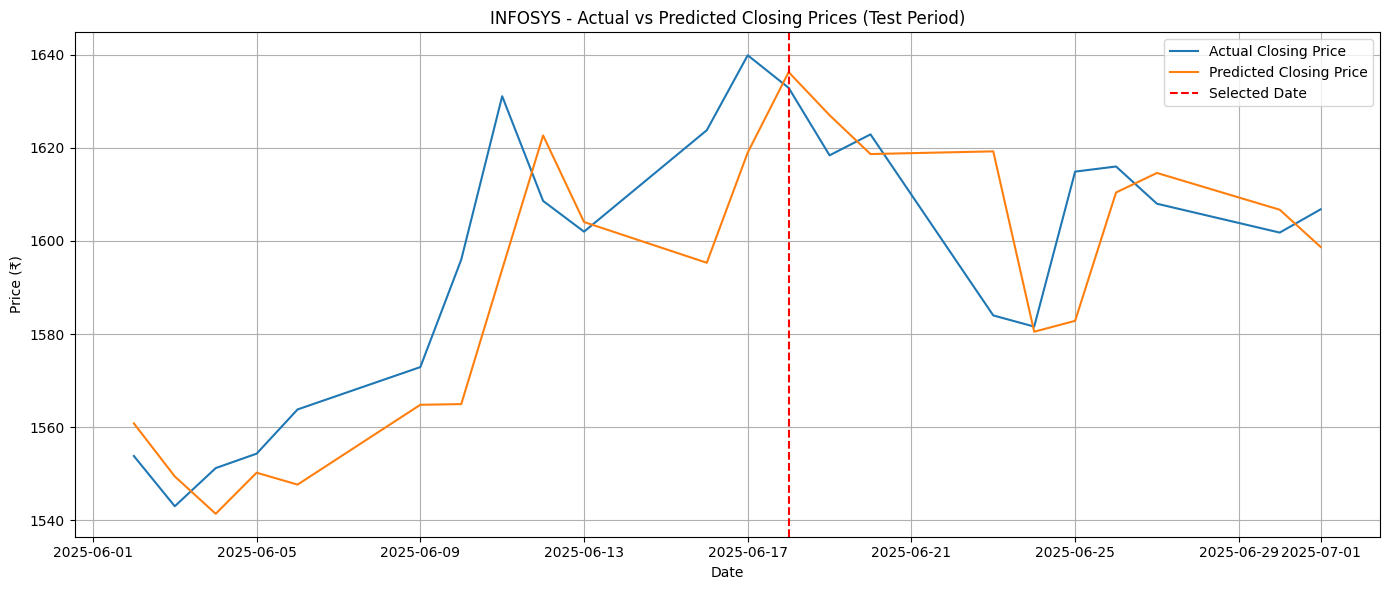

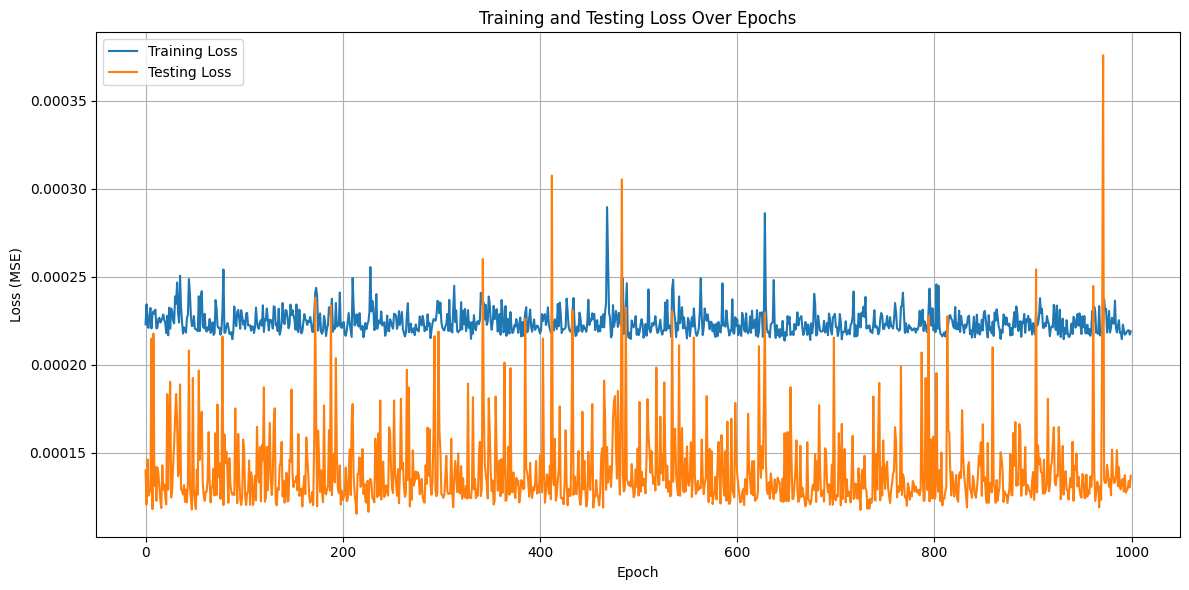

In [ ]:

# Train model with validation on test data
print("Training model for 1000 epochs...")
history = model.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Predict on test data
predicted_scaled = model.predict(X_test)
predicted = scaler.inverse_transform(predicted_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# --- Training Set Metrics ---
train_pred_scaled = model.predict(X_train)
train_pred = scaler.inverse_transform(train_pred_scaled)
train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

mse_train = np.mean((train_pred - train_actual)**2)
mae_train = np.mean(abs(train_pred - train_actual))
mape_train = np.mean(abs(train_pred - train_actual) / train_actual) * 100
accuracy_train = 100 - mape_train
avg_train_price = np.mean(train_actual)
mse_train_percent = (mse_train / avg_train_price) * 100
mae_train_percent = (mae_train / avg_train_price) * 100

# --- Test Set Metrics ---
mse = np.mean((predicted - actual) ** 2)
mae = np.mean(abs(predicted - actual))
avg_price = np.mean(actual)
mse_percent = (mse / avg_price) * 100
mae_percent = (mae / avg_price) * 100
mape = np.mean(abs(predicted - actual) / actual) * 100
accuracy = 100 - mape

# Print metrics
print("\n========== Training Set Metrics ==========")
print(f"MSE: {mse_train:.4f} ({mse_train_percent:.4f}% of avg price)")
print(f"MAE: {mae_train:.4f} ({mae_train_percent:.4f}% of avg price)")
print(f"Accuracy: {accuracy_train:.2f}%")

print("\n========== Test Set Metrics ==========")
print(f"MSE: {mse:.4f} ({mse_percent:.4f}% of avg price)")
print(f"MAE: {mae:.4f} ({mae_percent:.4f}% of avg price)")
print(f"Accuracy: {accuracy:.2f}%")
print("=========================================\n")

# Prompt user for date
while True:
    user_input = input("Enter a date between 2025-06-01 and 2025-07-01 (YYYY-MM-DD): ").strip()
    try:
        user_date = datetime.datetime.strptime(user_input, "%Y-%m-%d").date()
    except ValueError:
        print("Invalid format. Try again.")
        continue
    if not (date(2025, 6, 1) <= user_date <= date(2025, 7, 1)):
        print("Date out of range.")
        continue
    if user_date not in test_dates:
        print("Date not in test data.")
        continue
    break

# Find index
idx = np.where(test_dates == user_date)[0][0]
pred_price = predicted[idx][0]
act_price = actual[idx][0]
error_pct = abs(pred_price - act_price) / act_price * 100

# Display prediction
print(f"\nFor {user_date}:")
print(f"Predicted closing price: ₹{pred_price:.2f}")
print(f"Actual closing price: ₹{act_price:.2f}")
print(f"Absolute error: {error_pct:.2f}%")

# Plot actual vs predicted prices
plt.figure(figsize=(14, 6))
plt.plot(test_dates, actual, label="Actual Closing Price")
plt.plot(test_dates, predicted, label="Predicted Closing Price")
plt.axvline(x=np.datetime64(user_date), color="red", linestyle="--", label="Selected Date")
plt.xlabel("Date")
plt.ylabel("Price (₹)")
plt.title("INFOSYS - Actual vs Predicted Closing Prices (Test Period)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Combined loss plot
plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Testing Loss")
plt.title("Training and Testing Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Streaming output truncated to the last 5000 lines.
Epoch 11/2500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.1929e-04 - val_loss: 1.2738e-04
Epoch 12/2500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.2676e-04 - val_loss: 1.4044e-04
Epoch 13/2500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.4736e-04 - val_loss: 1.2573e-04
Epoch 14/2500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.2119e-04 - val_loss: 1.2793e-04
Epoch 15/2500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.1409e-04 - val_loss: 1.7914e-04
Epoch 16/2500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.2602e-04 - val_loss: 1.2892e-04
Epoch 17/2500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.2650e-04 - val_loss: 1.2468e-04
Epoch 18/2500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.0916e-04 - val_loss: 1.2973e-04
Epoch 19/2500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.3854e-04 - val_loss: 1.3583e-04
Epoch 20/2500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.1160e-04 - val_loss: 

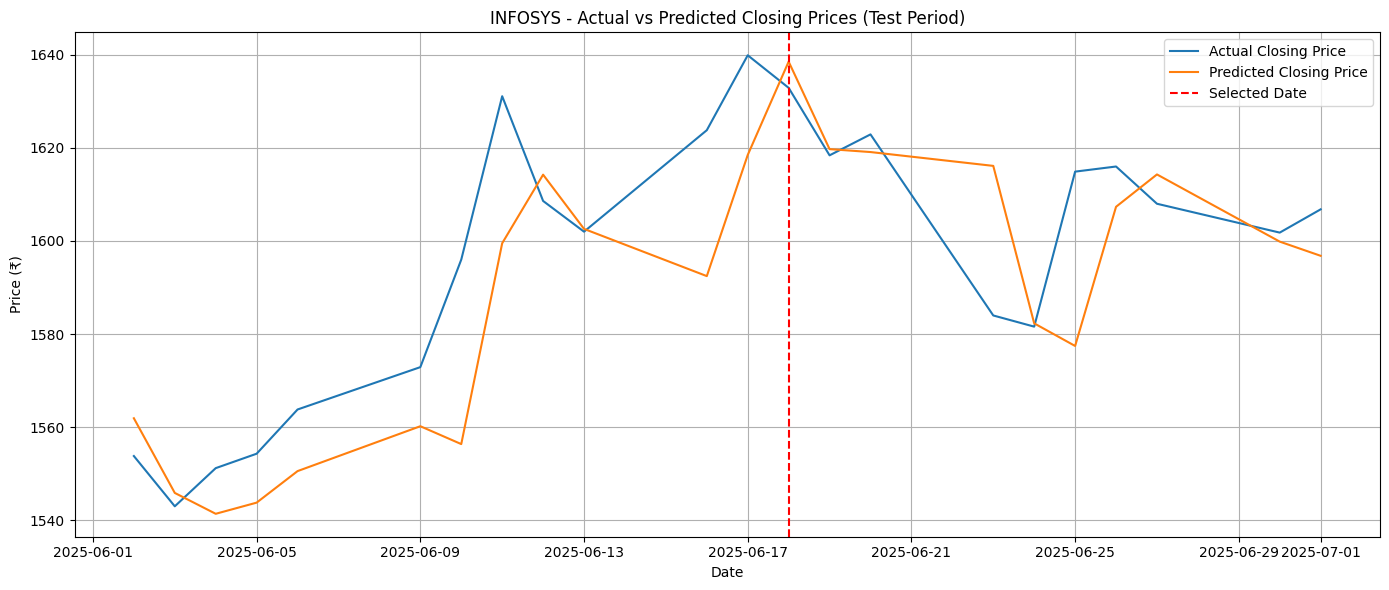

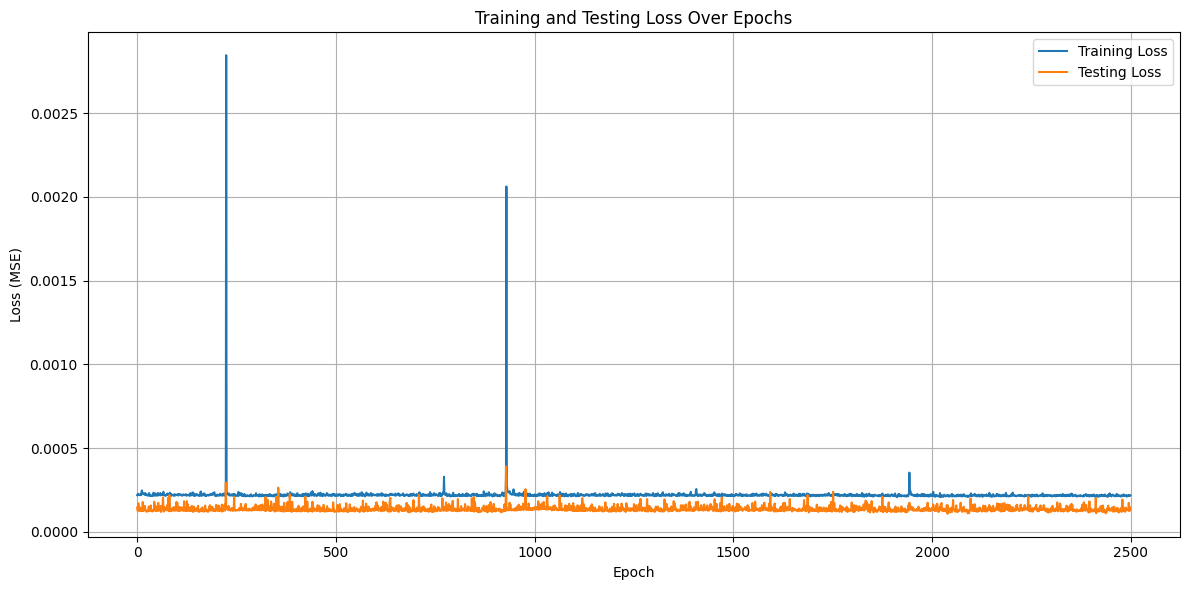

In [ ]:

# Train model with validation on test data
print("Training model for 2500 epochs...");
history = model.fit(
    X_train, y_train,
    epochs=2500,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Predict on test data
predicted_scaled = model.predict(X_test)
predicted = scaler.inverse_transform(predicted_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# --- Training Set Metrics ---
train_pred_scaled = model.predict(X_train)
train_pred = scaler.inverse_transform(train_pred_scaled)
train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

mse_train = np.mean((train_pred - train_actual)**2)
mae_train = np.mean(abs(train_pred - train_actual))
mape_train = np.mean(abs(train_pred - train_actual) / train_actual) * 100
accuracy_train = 100 - mape_train
avg_train_price = np.mean(train_actual)
mse_train_percent = (mse_train / avg_train_price) * 100
mae_train_percent = (mae_train / avg_train_price) * 100

# --- Test Set Metrics ---
mse = np.mean((predicted - actual) ** 2)
mae = np.mean(abs(predicted - actual))
avg_price = np.mean(actual)
mse_percent = (mse / avg_price) * 100
mae_percent = (mae / avg_price) * 100
mape = np.mean(abs(predicted - actual) / actual) * 100
accuracy = 100 - mape

# Print metrics
print("\n========== Training Set Metrics ==========")
print(f"MSE: {mse_train:.4f} ({mse_train_percent:.4f}% of avg price)")
print(f"MAE: {mae_train:.4f} ({mae_train_percent:.4f}% of avg price)")
print(f"Accuracy: {accuracy_train:.2f}%")

print("\n========== Test Set Metrics ==========")
print(f"MSE: {mse:.4f} ({mse_percent:.4f}% of avg price)")
print(f"MAE: {mae:.4f} ({mae_percent:.4f}% of avg price)")
print(f"Accuracy: {accuracy:.2f}%")
print("=========================================\n")

# Prompt user for date
while True:
    user_input = input("Enter a date between 2025-06-01 and 2025-07-01 (YYYY-MM-DD): ").strip()
    try:
        user_date = datetime.datetime.strptime(user_input, "%Y-%m-%d").date()
    except ValueError:
        print("Invalid format. Try again.")
        continue
    if not (date(2025, 6, 1) <= user_date <= date(2025, 7, 1)):
        print("Date out of range.")
        continue
    if user_date not in test_dates:
        print("Date not in test data.")
        continue
    break

# Find index
idx = np.where(test_dates == user_date)[0][0]
pred_price = predicted[idx][0]
act_price = actual[idx][0]
error_pct = abs(pred_price - act_price) / act_price * 100

# Display prediction
print(f"\nFor {user_date}:")
print(f"Predicted closing price: ₹{pred_price:.2f}")
print(f"Actual closing price: ₹{act_price:.2f}")
print(f"Absolute error: {error_pct:.2f}%")

# Plot actual vs predicted prices
plt.figure(figsize=(14, 6))
plt.plot(test_dates, actual, label="Actual Closing Price")
plt.plot(test_dates, predicted, label="Predicted Closing Price")
plt.axvline(x=np.datetime64(user_date), color="red", linestyle="--", label="Selected Date")
plt.xlabel("Date")
plt.ylabel("Price (₹)")
plt.title("INFOSYS - Actual vs Predicted Closing Prices (Test Period)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Combined loss plot
plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Testing Loss")
plt.title("Training and Testing Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Streaming output truncated to the last 5000 lines.
Epoch 2511/5000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 2.1365e-04 - val_loss: 1.4147e-04
Epoch 2512/5000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.9839e-04 - val_loss: 1.2036e-04
Epoch 2513/5000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.2279e-04 - val_loss: 1.4588e-04
Epoch 2514/5000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.9131e-04 - val_loss: 1.4847e-04
Epoch 2515/5000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.0436e-04 - val_loss: 1.3137e-04
Epoch 2516/5000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.0836e-04 - val_loss: 1.4784e-04
Epoch 2517/5000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.0861e-04 - val_loss: 1.2026e-04
Epoch 2518/5000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.9537e-04 - val_loss: 1.4315e-04
Epoch 2519/5000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.8994e-04 - val_loss: 1.4156e-04
Epoch 2520/5000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2.1

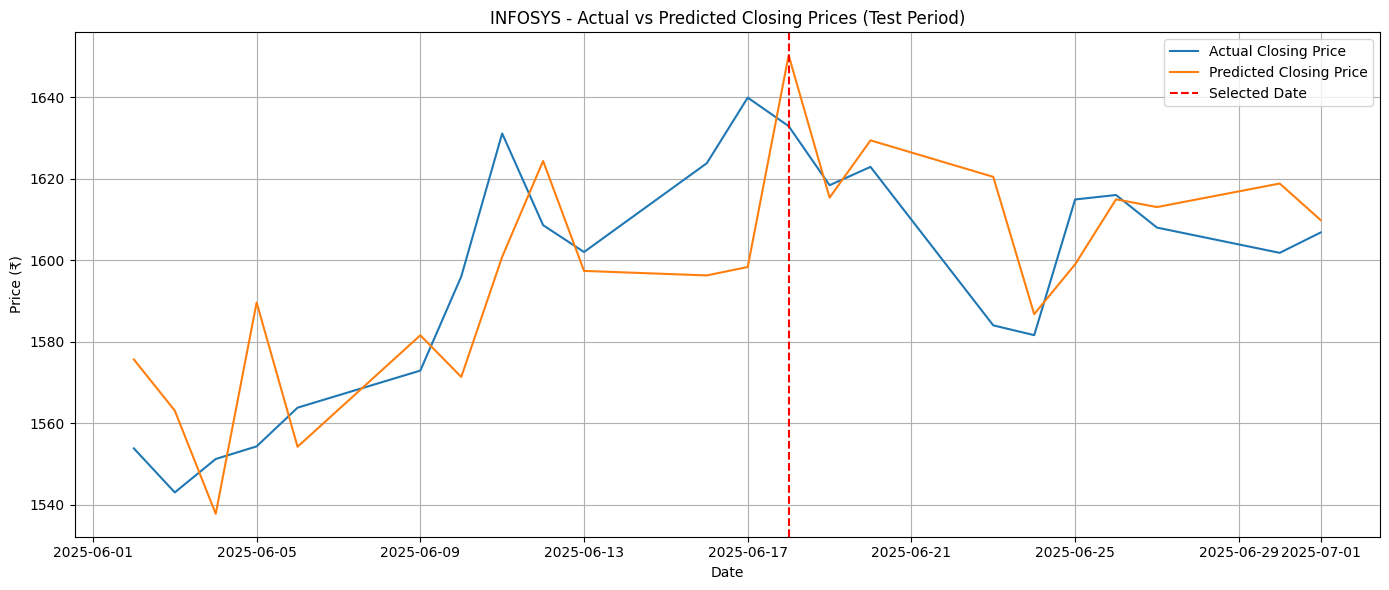

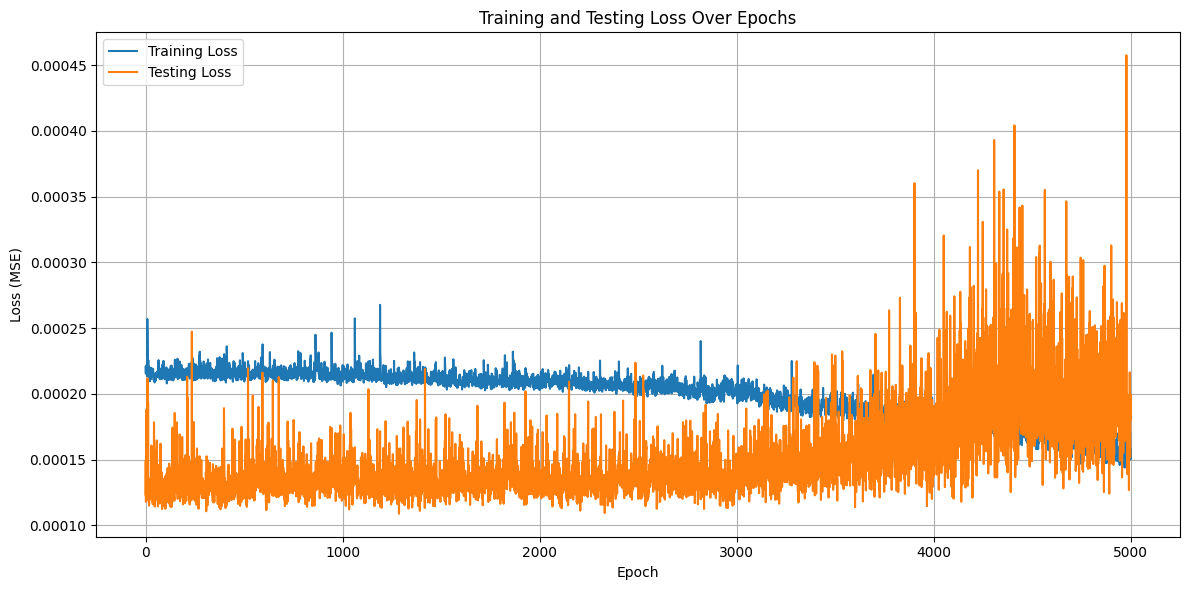

In [ ]:

# Train model with validation on test data
print("Training model for 5000 epochs...")
history = model.fit(
    X_train, y_train,
    epochs=5000,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Predict on test data
predicted_scaled = model.predict(X_test)
predicted = scaler.inverse_transform(predicted_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# --- Training Set Metrics ---
train_pred_scaled = model.predict(X_train)
train_pred = scaler.inverse_transform(train_pred_scaled)
train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

mse_train = np.mean((train_pred - train_actual)**2)
mae_train = np.mean(abs(train_pred - train_actual))
mape_train = np.mean(abs(train_pred - train_actual) / train_actual) * 100
accuracy_train = 100 - mape_train
avg_train_price = np.mean(train_actual)
mse_train_percent = (mse_train / avg_train_price) * 100
mae_train_percent = (mae_train / avg_train_price) * 100

# --- Test Set Metrics ---
mse = np.mean((predicted - actual) ** 2)
mae = np.mean(abs(predicted - actual))
avg_price = np.mean(actual)
mse_percent = (mse / avg_price) * 100
mae_percent = (mae / avg_price) * 100
mape = np.mean(abs(predicted - actual) / actual) * 100
accuracy = 100 - mape

# Print metrics
print("\n========== Training Set Metrics ==========")
print(f"MSE: {mse_train:.4f} ({mse_train_percent:.4f}% of avg price)")
print(f"MAE: {mae_train:.4f} ({mae_train_percent:.4f}% of avg price)")
print(f"Accuracy: {accuracy_train:.2f}%")

print("\n========== Test Set Metrics ==========")
print(f"MSE: {mse:.4f} ({mse_percent:.4f}% of avg price)")
print(f"MAE: {mae:.4f} ({mae_percent:.4f}% of avg price)")
print(f"Accuracy: {accuracy:.2f}%")
print("=========================================\n")

# Prompt user for date
while True:
    user_input = input("Enter a date between 2025-06-01 and 2025-07-01 (YYYY-MM-DD): ").strip()
    try:
        user_date = datetime.datetime.strptime(user_input, "%Y-%m-%d").date()
    except ValueError:
        print("Invalid format. Try again.")
        continue
    if not (date(2025, 6, 1) <= user_date <= date(2025, 7, 1)):
        print("Date out of range.")
        continue
    if user_date not in test_dates:
        print("Date not in test data.")
        continue
    break

# Find index
idx = np.where(test_dates == user_date)[0][0]
pred_price = predicted[idx][0]
act_price = actual[idx][0]
error_pct = abs(pred_price - act_price) / act_price * 100

# Display prediction
print(f"\nFor {user_date}:")
print(f"Predicted closing price: ₹{pred_price:.2f}")
print(f"Actual closing price: ₹{act_price:.2f}")
print(f"Absolute error: {error_pct:.2f}%")

# Plot actual vs predicted prices
plt.figure(figsize=(14, 6))
plt.plot(test_dates, actual, label="Actual Closing Price")
plt.plot(test_dates, predicted, label="Predicted Closing Price")
plt.axvline(x=np.datetime64(user_date), color="red", linestyle="--", label="Selected Date")
plt.xlabel("Date")
plt.ylabel("Price (₹)")
plt.title("INFOSYS - Actual vs Predicted Closing Prices (Test Period)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Combined loss plot
plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Testing Loss")
plt.title("Training and Testing Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-7-1873179857.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("INFY.NS", start="2020-01-01", end="2025-07-02")
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Streaming output truncated to the last 5000 lines.
Epoch 5011/7500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.2923e-04 - val_loss: 1.3288e-04
Epoch 5012/7500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.4142e-04 - val_loss: 1.8155e-04
Epoch 5013/7500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.1731e-04 - val_loss: 1.4196e-04
Epoch 5014/7500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.3056e-04 - val_loss: 1.5046e-04
Epoch 5015/7500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.3007e-04 - val_loss: 1.5032e-04
Epoch 5016/7500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.4060e-04 - val_loss: 1.8364e-04
Epoch 5017/7500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.4544e-04 - val_loss: 1.9350e-04
Epoch 5018/7500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.5603e-04 - val_loss: 1.3097e-04
Epoch 5019/7500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.5389e-04 - val_loss: 1.3137e-04
Epoch 5020/7500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.3391e-04 - 

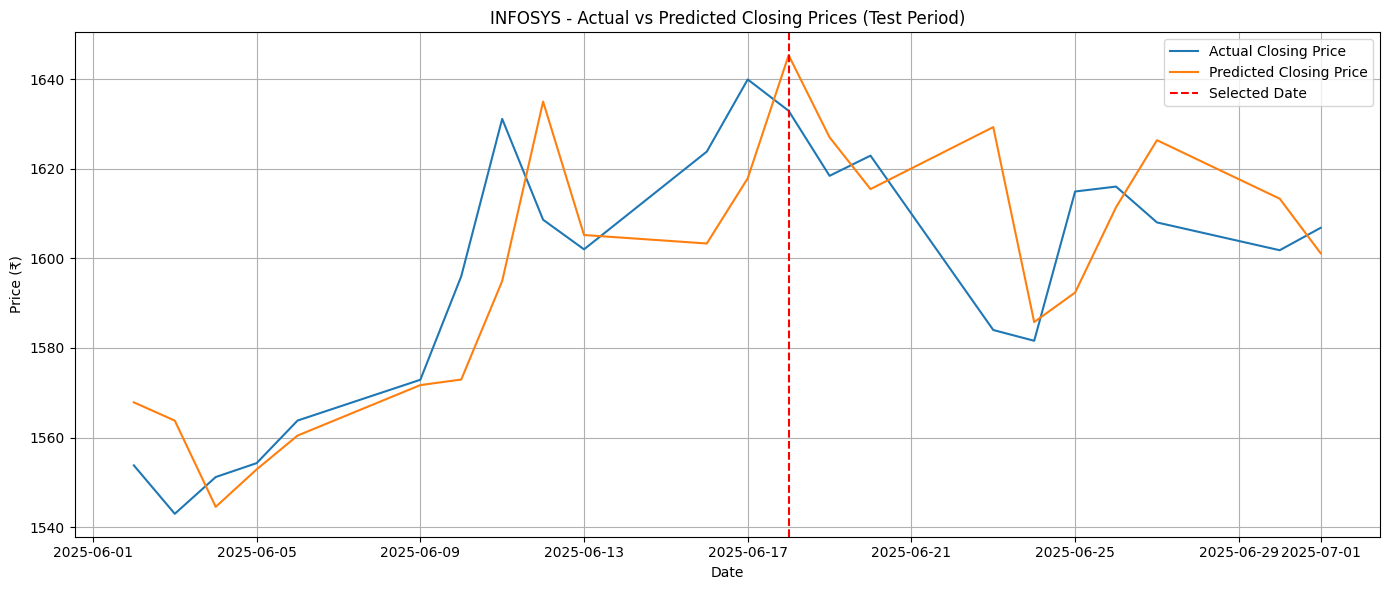

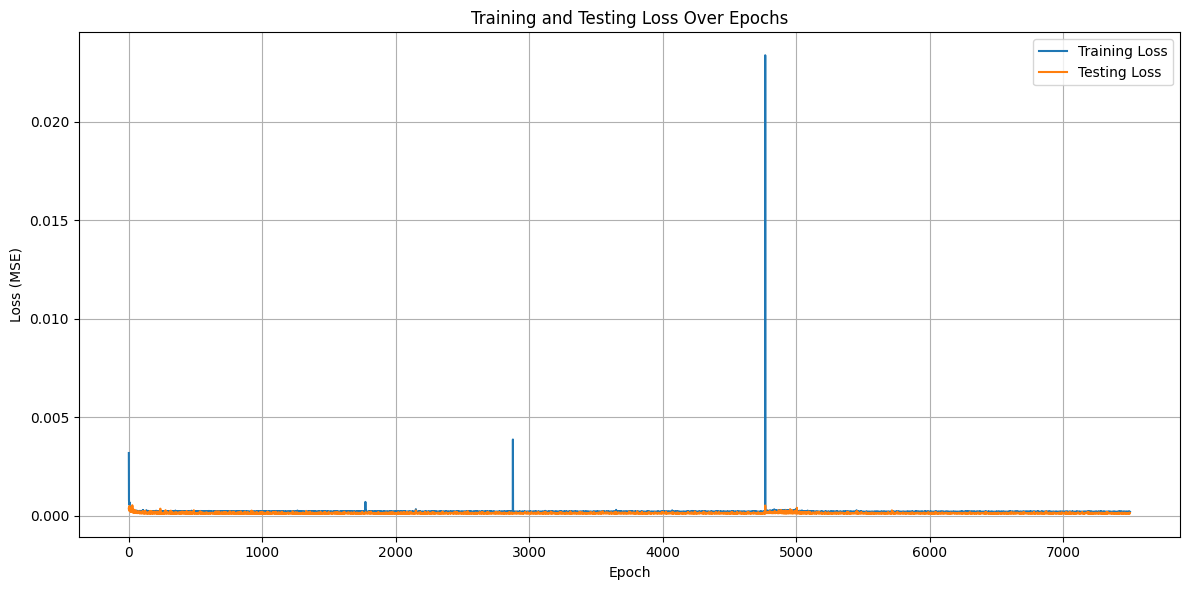

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import date
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler

# For reproducibility
np.random.seed(42)

# Download data
print("Downloading INFOSYS historical data...")
df = yf.download("INFY.NS", start="2020-01-01", end="2025-07-02")

if df.empty:
    print("ERROR: No data returned.")
    exit()

# Use only Close price
df = df[["Close"]]
df.reset_index(inplace=True)
df["Date"] = pd.to_datetime(df["Date"]).dt.date
df.sort_values("Date", inplace=True)

# Split train/test
train_df = df[df["Date"] <= date(2025, 5, 31)]
test_df = df[(df["Date"] >= date(2025, 6, 1)) & (df["Date"] <= date(2025, 7, 1))]

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(df["Close"].values.reshape(-1, 1))

# Create sequences
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(scaled_close)):
    X.append(scaled_close[i-sequence_length:i, 0])
    y.append(scaled_close[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Determine split index
split_index = len(train_df) - sequence_length
X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]
test_dates = df["Date"].values[sequence_length + split_index:]

# Build SimpleRNN model
model = Sequential()
model.add(SimpleRNN(50, activation="tanh", input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")


# Train model with validation on test data
print("Training model for 7500 epochs...")
history = model.fit(
    X_train, y_train,
    epochs=7500,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Predict on test data
predicted_scaled = model.predict(X_test)
predicted = scaler.inverse_transform(predicted_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# --- Training Set Metrics ---
train_pred_scaled = model.predict(X_train)
train_pred = scaler.inverse_transform(train_pred_scaled)
train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

mse_train = np.mean((train_pred - train_actual)**2)
mae_train = np.mean(abs(train_pred - train_actual))
mape_train = np.mean(abs(train_pred - train_actual) / train_actual) * 100
accuracy_train = 100 - mape_train
avg_train_price = np.mean(train_actual)
mse_train_percent = (mse_train / avg_train_price) * 100
mae_train_percent = (mae_train / avg_train_price) * 100

# --- Test Set Metrics ---
mse = np.mean((predicted - actual) ** 2)
mae = np.mean(abs(predicted - actual))
avg_price = np.mean(actual)
mse_percent = (mse / avg_price) * 100
mae_percent = (mae / avg_price) * 100
mape = np.mean(abs(predicted - actual) / actual) * 100
accuracy = 100 - mape

# Print metrics
print("\n========== Training Set Metrics ==========")
print(f"MSE: {mse_train:.4f} ({mse_train_percent:.4f}% of avg price)")
print(f"MAE: {mae_train:.4f} ({mae_train_percent:.4f}% of avg price)")
print(f"Accuracy: {accuracy_train:.2f}%")

print("\n========== Test Set Metrics ==========")
print(f"MSE: {mse:.4f} ({mse_percent:.4f}% of avg price)")
print(f"MAE: {mae:.4f} ({mae_percent:.4f}% of avg price)")
print(f"Accuracy: {accuracy:.2f}%")
print("=========================================\n")

# Prompt user for date
while True:
    user_input = input("Enter a date between 2025-06-01 and 2025-07-01 (YYYY-MM-DD): ").strip()
    try:
        user_date = datetime.datetime.strptime(user_input, "%Y-%m-%d").date()
    except ValueError:
        print("Invalid format. Try again.")
        continue
    if not (date(2025, 6, 1) <= user_date <= date(2025, 7, 1)):
        print("Date out of range.")
        continue
    if user_date not in test_dates:
        print("Date not in test data.")
        continue
    break

# Find index
idx = np.where(test_dates == user_date)[0][0]
pred_price = predicted[idx][0]
act_price = actual[idx][0]
error_pct = abs(pred_price - act_price) / act_price * 100

# Display prediction
print(f"\nFor {user_date}:")
print(f"Predicted closing price: ₹{pred_price:.2f}")
print(f"Actual closing price: ₹{act_price:.2f}")
print(f"Absolute error: {error_pct:.2f}%")

# Plot actual vs predicted prices
plt.figure(figsize=(14, 6))
plt.plot(test_dates, actual, label="Actual Closing Price")
plt.plot(test_dates, predicted, label="Predicted Closing Price")
plt.axvline(x=np.datetime64(user_date), color="red", linestyle="--", label="Selected Date")
plt.xlabel("Date")
plt.ylabel("Price (₹)")
plt.title("INFOSYS - Actual vs Predicted Closing Prices (Test Period)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Combined loss plot
plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Testing Loss")
plt.title("Training and Testing Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-1-3137391742.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("INFY.NS", start="2020-01-01", end="2025-07-02")
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Streaming output truncated to the last 5000 lines.
Epoch 7511/10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.9764e-04 - val_loss: 1.2891e-04
Epoch 7512/10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.2161e-04 - val_loss: 1.5032e-04
Epoch 7513/10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.9947e-04 - val_loss: 1.7647e-04
Epoch 7514/10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.1881e-04 - val_loss: 1.4185e-04
Epoch 7515/10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.0936e-04 - val_loss: 1.3502e-04
Epoch 7516/10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.4129e-04 - val_loss: 1.3518e-04
Epoch 7517/10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.8997e-04 - val_loss: 1.3552e-04
Epoch 7518/10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.0753e-04 - val_loss: 1.3989e-04
Epoch 7519/10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.0982e-04 - val_loss: 1.3831e-04
Epoch 7520/10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step -

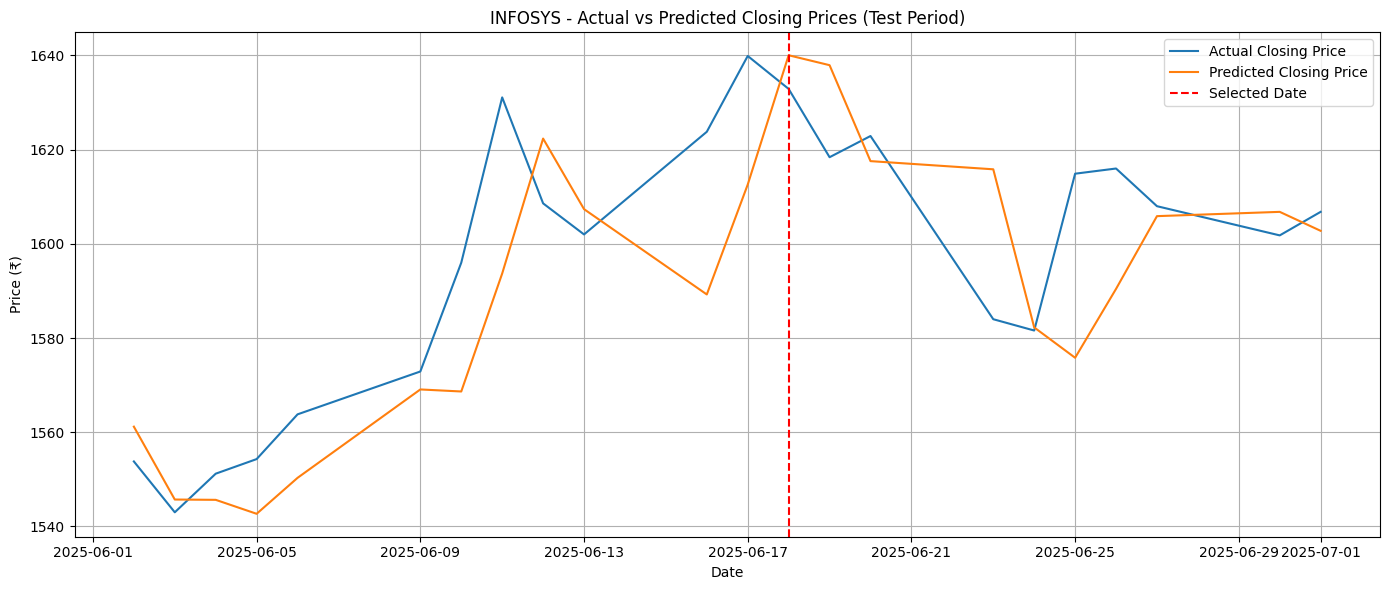

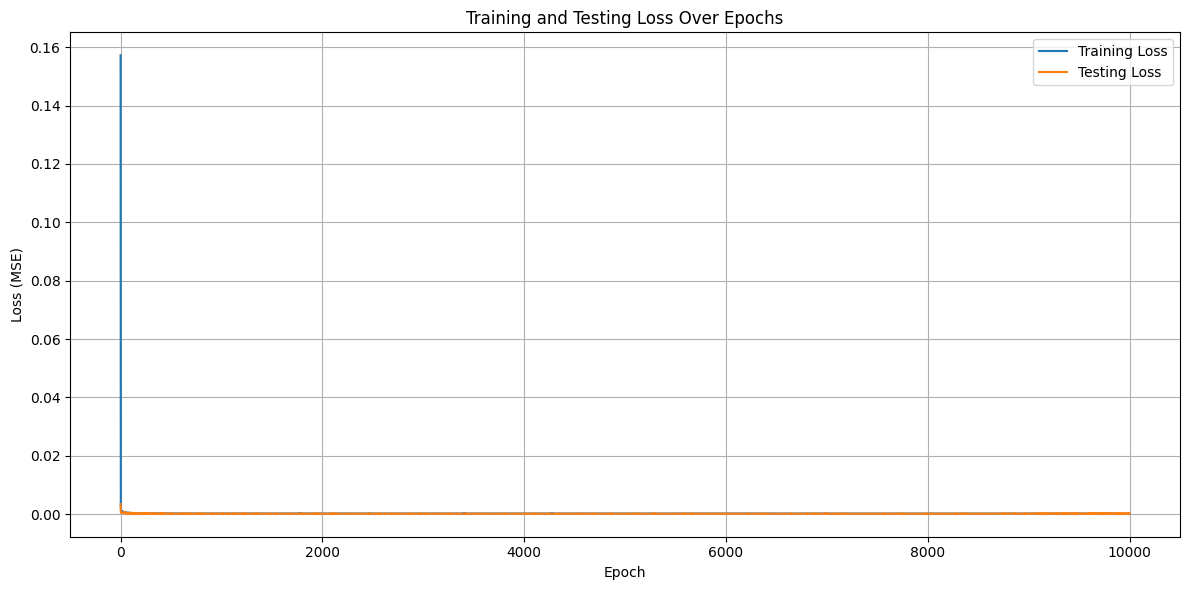

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import date
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler

# For reproducibility
np.random.seed(42)

# Download data
print("Downloading INFOSYS historical data...")
df = yf.download("INFY.NS", start="2020-01-01", end="2025-07-02")

if df.empty:
    print("ERROR: No data returned.")
    exit()

# Use only Close price
df = df[["Close"]]
df.reset_index(inplace=True)
df["Date"] = pd.to_datetime(df["Date"]).dt.date
df.sort_values("Date", inplace=True)

# Split train/test
train_df = df[df["Date"] <= date(2025, 5, 31)]
test_df = df[(df["Date"] >= date(2025, 6, 1)) & (df["Date"] <= date(2025, 7, 1))]

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(df["Close"].values.reshape(-1, 1))

# Create sequences
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(scaled_close)):
    X.append(scaled_close[i-sequence_length:i, 0])
    y.append(scaled_close[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Determine split index
split_index = len(train_df) - sequence_length
X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]
test_dates = df["Date"].values[sequence_length + split_index:]

# Build SimpleRNN model
model = Sequential()
model.add(SimpleRNN(50, activation="tanh", input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")


# Train model with validation on test data
print("Training model for 10000 epochs...")
history = model.fit(
    X_train, y_train,
    epochs=10000,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Predict on test data
predicted_scaled = model.predict(X_test)
predicted = scaler.inverse_transform(predicted_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# --- Training Set Metrics ---
train_pred_scaled = model.predict(X_train)
train_pred = scaler.inverse_transform(train_pred_scaled)
train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

mse_train = np.mean((train_pred - train_actual)**2)
mae_train = np.mean(abs(train_pred - train_actual))
mape_train = np.mean(abs(train_pred - train_actual) / train_actual) * 100
accuracy_train = 100 - mape_train
avg_train_price = np.mean(train_actual)
mse_train_percent = (mse_train / avg_train_price) * 100
mae_train_percent = (mae_train / avg_train_price) * 100

# --- Test Set Metrics ---
mse = np.mean((predicted - actual) ** 2)
mae = np.mean(abs(predicted - actual))
avg_price = np.mean(actual)
mse_percent = (mse / avg_price) * 100
mae_percent = (mae / avg_price) * 100
mape = np.mean(abs(predicted - actual) / actual) * 100
accuracy = 100 - mape

# Print metrics
print("\n========== Training Set Metrics ==========")
print(f"MSE: {mse_train:.4f} ({mse_train_percent:.4f}% of avg price)")
print(f"MAE: {mae_train:.4f} ({mae_train_percent:.4f}% of avg price)")
print(f"Accuracy: {accuracy_train:.2f}%")

print("\n========== Test Set Metrics ==========")
print(f"MSE: {mse:.4f} ({mse_percent:.4f}% of avg price)")
print(f"MAE: {mae:.4f} ({mae_percent:.4f}% of avg price)")
print(f"Accuracy: {accuracy:.2f}%")
print("=========================================\n")

# Prompt user for date
while True:
    user_input = input("Enter a date between 2025-06-01 and 2025-07-01 (YYYY-MM-DD): ").strip()
    try:
        user_date = datetime.datetime.strptime(user_input, "%Y-%m-%d").date()
    except ValueError:
        print("Invalid format. Try again.")
        continue
    if not (date(2025, 6, 1) <= user_date <= date(2025, 7, 1)):
        print("Date out of range.")
        continue
    if user_date not in test_dates:
        print("Date not in test data.")
        continue
    break

# Find index
idx = np.where(test_dates == user_date)[0][0]
pred_price = predicted[idx][0]
act_price = actual[idx][0]
error_pct = abs(pred_price - act_price) / act_price * 100

# Display prediction
print(f"\nFor {user_date}:")
print(f"Predicted closing price: ₹{pred_price:.2f}")
print(f"Actual closing price: ₹{act_price:.2f}")
print(f"Absolute error: {error_pct:.2f}%")

# Plot actual vs predicted prices
plt.figure(figsize=(14, 6))
plt.plot(test_dates, actual, label="Actual Closing Price")
plt.plot(test_dates, predicted, label="Predicted Closing Price")
plt.axvline(x=np.datetime64(user_date), color="red", linestyle="--", label="Selected Date")
plt.xlabel("Date")
plt.ylabel("Price (₹)")
plt.title("INFOSYS - Actual vs Predicted Closing Prices (Test Period)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Combined loss plot
plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Testing Loss")
plt.title("Training and Testing Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()